# What is torch.nn Really?

## 1. MNIST Data Setup

In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path('data')
PATH = DATA_PATH / 'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

**[pickle -> memory]** This dataset is in numpy array format, and has been stored using pickle

In [3]:
import pickle
import gzip

In [4]:
with gzip.open((PATH / FILENAME).as_posix(), 'rb') as fr:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(fr, encoding='latin-1')

**[Reshape]** Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). We need to reshape it to 2d first.

In [5]:
from matplotlib import pyplot
import numpy as np

(50000, 784)


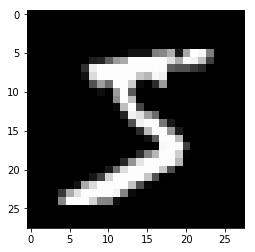

In [6]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap='gray')
print(x_train.shape)

**[numpy array -> Tensor]** PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

In [7]:
import torch

In [8]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## 2. Neural Net From Scratch (No torch.nn)

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. When setting ***requires_grad=True***, PyTorch will **record all of the operations done on the tensor**, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set requires_grad **after the initialization**, since we don't want that step included in the gradient!

> 刘尧：设置requires_grad=True后，PyTorch**只是记录tensor上的所有操作和中间变量**，以用于随后backward时使用这些中间变量，仅此而已，没太多复杂逻辑。

> 刘尧：设置之前的操作不会被包括在backward的梯度计算中，之后的操作会，除非Wrap在**with torch.no_grad()**中，所以要注意设置的时机！

In [9]:
import math

In [10]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can use **any standard Python function (or callable object) as a model**! So let's just write a plain matrix multiplication and broadcasted addition to create a simple linear model! We also need an activation function, so we'll write *log_softmax* and use it.

Remember: although PyTorch provides lots of pre-written loss functions, activation functions,and so forth, you can easily write your own **using plain Python**. PyTorch will even create fast GPU or vectorized CPU code for your function automatically!

> 刘尧：PyTorch支持我们使用plain Python来创建自己的model和function！哎呀真是太方便太灵活太有爱了！我喜欢~

In [11]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)  # x是Tensor 像对待numpy array那样来自定义函数！当然，api使用Tensor的

def model(xb):
    return log_softmax(xb @ weights + bias)  # @ means dot production

In [12]:
bs = 64  # batch size
xb, yb = x_train[0: bs], y_train[0: bs]
preds = model(xb)
print(preds[0], preds.shape)

tensor([-2.1582, -2.5963, -2.2912, -2.2727, -2.0091, -2.7189, -2.2418, -2.5606,
        -2.5164, -1.9562], grad_fn=<SelectBackward>) torch.Size([64, 10])


As we see, the *preds* tensor contains not only tensor values, but also **a gradient function**, which will be used later to do backward.

Let's implement negative log-likelihood to use as the loss function (again, we can just use standard Python), and then implement a function to calculate the accuracy of model. 

In [13]:
def nll(input, target):
    return - input[range(target.shape[0]), target].mean()  # target所对应的那些“列”的均值

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [14]:
loss_func = nll
print(loss_func(preds, yb))
print(accuracy(preds, yb))

tensor(2.3263, grad_fn=<NegBackward>)
tensor(0.0781)


Now we run a training loop. For each iteration, we will:

- select a min-batch of data (of size *bs*)

- use the model to make a predictions

- calculate the loss

- ***loss.backward()*** updates the gradients of the model, in this case, *weights* and *bias*

We use these gradients to update the weights and bias within the ***torch.no_grad()*** context manager, because we don't want these actions to **be recorded for our next calculation of the gradients**!

> 刘尧：设置了weight和bias的require_grad=True后，随后所有针对这两者的操作都会被record到梯度计算中，当某些操作不需要被record时，需要使用**torch.no_grad()**包裹这些操作！

Before next training loop, we should set the gradients to zero. Otherwise, our gradients would record a running tally of all the operations that had happened. (i.e. *loss.backward()* **adds the gradients to whatever is already stored, rather than replacing them**).

> 刘尧：loss.backward()会**累加计算**所有已存在的gradient，而非重新替换！所以**每个mini-batch(而非epoch)后**要及时对weights和bias的梯度归零！如：***weights.grad.zero_()***和***bias.grad.zero_()***

In [15]:
from IPython.core.debugger import set_trace  # 

In [19]:
lr = 0.001
epochs = 5
loss_func = nll

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        set_trace
        # Training
        xb, yb = x_train[i * bs: (i + 1) * bs], y_train[i * bs: (i + 1) * bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        acc = accuracy(pred, yb)

        # Validation  注意，特别注意！这么写validation是不对的，每次train/val的loss和acc应该是每个epoch里遍历所有mini-batch后的均值！ 此处只是反例示范~啦啦啦~~
        pred_val = model(x_valid)
        val_loss = loss_func(pred_val, y_valid)
        val_acc = accuracy(pred_val, y_valid)
        
        # Log
        if i % 300 == 0:
            print(f'Epoch: {epoch} --- i: {i + 1: 4d} --- loss: {loss.item(): .4f} --- acc: {acc: .4f} --- val_loss: {val_loss: .4f} --- val_acc: {val_acc: .4f}')
        
        loss.backward()
        with torch.no_grad():
            weights -= lr * weights.grad
            bias -= lr * bias.grad
            weights.grad.zero_()
            bias.grad.zero_()

Epoch: 0 --- i:    1 --- loss:  0.6862 --- acc:  0.8438 --- val_loss:  0.6312 --- val_acc:  0.8684
Epoch: 0 --- i:  301 --- loss:  0.6626 --- acc:  0.8125 --- val_loss:  0.6216 --- val_acc:  0.8695
Epoch: 0 --- i:  601 --- loss:  0.5753 --- acc:  0.8906 --- val_loss:  0.6125 --- val_acc:  0.8710
Epoch: 1 --- i:    1 --- loss:  0.6610 --- acc:  0.8594 --- val_loss:  0.6073 --- val_acc:  0.8713
Epoch: 1 --- i:  301 --- loss:  0.6440 --- acc:  0.8281 --- val_loss:  0.5991 --- val_acc:  0.8715
Epoch: 1 --- i:  601 --- loss:  0.5545 --- acc:  0.8906 --- val_loss:  0.5913 --- val_acc:  0.8734
Epoch: 2 --- i:    1 --- loss:  0.6392 --- acc:  0.8750 --- val_loss:  0.5867 --- val_acc:  0.8731
Epoch: 2 --- i:  301 --- loss:  0.6281 --- acc:  0.8438 --- val_loss:  0.5797 --- val_acc:  0.8730
Epoch: 2 --- i:  601 --- loss:  0.5365 --- acc:  0.8906 --- val_loss:  0.5729 --- val_acc:  0.8747
Epoch: 3 --- i:    1 --- loss:  0.6200 --- acc:  0.8750 --- val_loss:  0.5689 --- val_acc:  0.8752
Epoch: 3 -

## 3. Using torch.nn.functional

> **activation & loss functions --> torch.nn.functional**

We will now refactor our code, so that it does the same things as before, only we'll start taking advantage of PyTorch's *nn* classes to make it more concise and flexible. At each step from here, we should be making our code one or more: **shorter, more understandable, and/or more flexible**.

Frist and easiest step: replacing our hand-written activation and loss functions with ***torch.nn.functional***.

In [20]:
import torch.nn.functional as F

In [21]:
loss_func = F.cross_entropy  # change

def model(xb):
    return xb @ weights + bias  # Note that we no longer call log_softmax in the model function

## 4. Refactor using nn.Module

> **model function & weights/bias variable & training loop --> nn.Moduel & nn.Parameter**

We want to create a class that holds our weights, bias and method for the forward step. We will use a class instead of just using functions.

> 刘尧：此处的model其实跟一般PyTorch中定义的model没本质区别，此处*\_\_init\_\_*和*forward*里是low-level的变量和操作如**weights,bias和它们加减相乘**，而一般model是high-level的比如**Layer和Lyaer(x)**

In [22]:
from torch import nn

In [23]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))  # change
        self.bias = nn.Parameter(torch.zeros(10))                           # change
        
    def forward(self, xb):
        return xb @ self.weights * self.bias

In [24]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3026, grad_fn=<NllLossBackward>)


In [29]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            xb, yb = x_train[i * bs: (i + 1) * bs], y_train[i * bs: (i + 1) * bs]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            if i % 300 == 0:
                print(f'Epoch: {epoch} --- i: {i + 1: 4d} --- loss: {loss.item(): .4f}')
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad()

In [30]:
fit()

Epoch: 0 --- i:    1 --- loss:  2.2640
Epoch: 0 --- i:  301 --- loss:  2.2454
Epoch: 0 --- i:  601 --- loss:  2.2683
Epoch: 1 --- i:    1 --- loss:  2.2420
Epoch: 1 --- i:  301 --- loss:  2.2118
Epoch: 1 --- i:  601 --- loss:  2.2480
Epoch: 2 --- i:    1 --- loss:  2.2087
Epoch: 2 --- i:  301 --- loss:  2.1616
Epoch: 2 --- i:  601 --- loss:  2.2176
Epoch: 3 --- i:    1 --- loss:  2.1598
Epoch: 3 --- i:  301 --- loss:  2.0897
Epoch: 3 --- i:  601 --- loss:  2.1730
Epoch: 4 --- i:    1 --- loss:  2.0906
Epoch: 4 --- i:  301 --- loss:  1.9914
Epoch: 4 --- i:  601 --- loss:  2.1087


## 5. Refactor using nn.Linear

> **self.weights & self.bias & xb @ self.weights + self.bias --> nn.Linear**

Instead of manually defining and initializing *self.weights* and *self.bias*, and calculating *xb @ self.weights + self.bias*, we will use the PyTorch class ***nn.Linear*** for a linear layer.

In [31]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)  # change
        
    def forward(self, xb):
        return self.linear(xb)

In [32]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3254, grad_fn=<NllLossBackward>)


## 6. Refactor using optim

> **param -= param.grad * lr & model.zero_grad() --> torch.optim**

Instead of manually updating each parameter, we can use ***step*** method in *torch.optim* to take a forward step.

In [33]:
from torch import optim

In [35]:
model = Mnist_Logistic()
optimizer = optim.SGD(model.parameters(), lr=lr)
print(loss_func(model(xb), yb))

tensor(2.2828, grad_fn=<NllLossBackward>)


In [36]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = x_train[i * bs: (i + 1) * bs], y_train[i * bs: (i + 1) * bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        if i % 300 == 0:
            print(f'Epoch: {epoch} --- i: {i + 1: 4d} --- loss: {loss.item(): .4f}')
            
        loss.backward()
        optimizer.step()       # change
        optimizer.zero_grad()  # change

Epoch: 0 --- i:    1 --- loss:  2.3240
Epoch: 0 --- i:  301 --- loss:  1.9733
Epoch: 0 --- i:  601 --- loss:  1.7667
Epoch: 1 --- i:    1 --- loss:  1.7062
Epoch: 1 --- i:  301 --- loss:  1.4404
Epoch: 1 --- i:  601 --- loss:  1.3340
Epoch: 2 --- i:    1 --- loss:  1.3534
Epoch: 2 --- i:  301 --- loss:  1.1556
Epoch: 2 --- i:  601 --- loss:  1.0871
Epoch: 3 --- i:    1 --- loss:  1.1438
Epoch: 3 --- i:  301 --- loss:  0.9905
Epoch: 3 --- i:  601 --- loss:  0.9338
Epoch: 4 --- i:    1 --- loss:  1.0081
Epoch: 4 --- i:  301 --- loss:  0.8857
Epoch: 4 --- i:  601 --- loss:  0.8308


## 7. Refactor using Dataset

> **x_train[i \* bs, (i + 1) \* bs] & y_train[...] --> torch.utils.data.TensorDataset**

PyTorch's ***TensorDataset*** is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the 1st dimension of a tensor.

In [38]:
from torch.utils.data import TensorDataset

In [39]:
train_ds = TensorDataset(x_train, y_train)  # TensorDataset VS Dataset： 前者继承后者，后者不宜直接使用，前者可直接使用于多个Tensor，后者不可

In [41]:
model = Mnist_Logistic()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: (i + 1) * bs]  # Change: xb, yb一起从train_ds中indexing代替它们分别indexing
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

## 8. Refactor using DataLoader

> **for i in range((n - 1) // bs + 1) --> torch.utils.data.DataLoader**

PyTorch's *DataLoader* is responsible for **managing batches**. We can create a *DataLoader* from any *Dataset*. *DataLoader* gives us each mini-batch automatically, making it easier to iterate over batches.

In [42]:
from torch.utils.data import DataLoader

In [43]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [44]:
model = Mnist_Logistic()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for xb, yb in train_dl:  # change: 直接使用iterable的train_dl，代替手动计算循环次数和对应的indices！
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Thanks to PyTorch's ***nn.Module, nn.Parameter, Dataset and DataLoader***, our training loop is now dramatically smaller and easier to understand.

## 9. Add Validation

In training loop, we always should also have a **validation set**, in order to identify if it's overfitting.

**Shuffling the training data** is important to prevent correlation between batches and overfitting. We don't shuffle the validation data.

For the validation set, we'll use **a batch size that is twice as large as that for the training set**. This is because the validation set doesn't need backpropagation and thus takes less memory (it doesn't need to store the memory).

In [48]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)  # shuffle=True

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)            # shuffle=False, batch_size变为2倍

In [49]:
model = Mnist_Logistic()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    # Training
    model.train()            # 之前没这句：默认是Training Phase；现在加这句：各epoch之间要来回切换
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Validation
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    print(f'Epoch: {epoch: 3d}  val_loss: {valid_loss / len(valid_dl): .4f}')

Epoch:   0  val_loss:  1.6839
Epoch:   1  val_loss:  1.3178
Epoch:   2  val_loss:  1.0999
Epoch:   3  val_loss:  0.9595
Epoch:   4  val_loss:  0.8627


## 10. Create fit() and get_date()

## 11. Switch to CNN

## 12. nn.Sequential

## 13. Wrapping DataLoader

## 14. Using your GPU

## 15. Closing thoughts